In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

## Load simulation data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Reduced_Order_trunklength_Loc5_restrict_h')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

STATS = np.load(STATS_PATH)
summ_stats = STATS['x']
labels = STATS['y']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi', 'l_t']


### Transform labels

#### Orientation

In [3]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [4]:
has_yshift = 'y' in label_list and STATS['ys'].size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = STATS['ys']
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0],inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,vx,vy,vz
1116,-60.488650,182.408933,0.358518,366.173405,0.466911,0.811643,-0.351041
1001,-54.294945,197.308134,0.459311,358.587009,0.446242,0.854176,-0.266929
1922,-52.799861,195.229928,0.390493,123.267210,0.615582,0.729614,-0.297864
4628,-52.604881,196.612400,-0.131100,209.580577,-0.543557,0.805696,-0.235371
2297,-49.855234,191.964448,-0.194988,841.365707,-0.558155,0.804854,-0.201676
...,...,...,...,...,...,...,...
1875,237.278943,199.085089,-0.040381,573.905385,0.207633,0.974510,-0.084959
4739,239.967030,193.611225,-0.489896,314.620728,-0.146535,0.968163,-0.202950
1919,244.807970,194.369721,0.238725,446.761317,-0.016228,0.995195,-0.096559
1392,244.885525,195.934933,0.105586,668.384185,-0.023675,0.998099,-0.056909


### Normalizing labels

#### Set bounds for y shift

In [5]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))
#     labels = labels[df_la_idx,:]
#     summ_stats = summ_stats[df_la_idx,:]
#     with pd.option_context('display.max_rows',10):
#         display(df_la.loc[df_la_idx])

print(json.dumps(ranges))

12.00% outside bounds.
{"x": [-50, 50], "y": [-1200, 1200], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [15.0, 865.0], "vx": [-1.0, 1.0], "vy": [-1.0, 1.0], "vz": [-1.0, 1.0], "ys": [-150, 150]}


#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,vx,vy,vz
0,0.105926,-0.545328,0.037867,-0.223231,-0.138682,0.860801,0.489683
1,0.058845,-0.366483,0.533298,-0.223231,0.662879,0.740817,-0.108540
2,0.069431,0.594731,-0.118573,-0.223231,-0.233748,0.905104,0.355175
3,0.175893,0.352509,-0.009053,-0.223231,-0.179952,0.720016,0.670220
4,0.596192,-0.217781,-0.441136,-0.223231,0.144645,0.820484,-0.553067
...,...,...,...,...,...,...,...
5995,0.132592,-0.160493,-0.834186,-0.760861,-0.336148,0.938450,0.079471
5996,0.934925,-0.212319,0.047885,-0.760861,-0.310209,0.882788,-0.352782
5997,0.084090,-0.082288,0.185007,-0.760861,0.591362,0.804725,-0.052043
5998,1.120212,0.841172,-0.103618,-0.760861,-0.141611,0.840166,-0.523514


## Build model

In [7]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

isTrain = True
model_name = 'FCN_batch256'
if direction_vec:
    model_name += '_dv'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name + '.pth')
SAVE_PATH = os.path.join(TRIAL_PATH, model_name + '.txt')

model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=len(label_list))

## Train model

In [8]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=256, shuffle=True)
if isTrain:
    history, files = train_regression(model, train_loader, test_loader, epochs=100, learning_rate=0.001, decay_rate=0.98)
    model.eval()
    torch.save(model.state_dict(), MODEL_PATH)
    with open(SAVE_PATH, 'w') as f:
        f.writelines(s + '\n' for s in files)

  2%|▊                                         | 2/100 [00:00<00:19,  4.92it/s]

Training Loss: 3.949807822704315 Validation Loss: 1.0346037149429321


 12%|████▉                                    | 12/100 [00:02<00:16,  5.35it/s]

Training Loss: 1.4336307421326637 Validation Loss: 0.46629055589437485


 22%|█████████                                | 22/100 [00:04<00:14,  5.32it/s]

Training Loss: 1.1089174188673496 Validation Loss: 0.3710573874413967


 32%|█████████████                            | 32/100 [00:06<00:12,  5.34it/s]

Training Loss: 0.9154875837266445 Validation Loss: 0.29978374019265175


 41%|████████████████▊                        | 41/100 [00:08<00:12,  4.85it/s]

Training Loss: 0.7885851003229618 Validation Loss: 0.2709447592496872


 52%|█████████████████████▎                   | 52/100 [00:10<00:09,  4.96it/s]

Training Loss: 0.7185400724411011 Validation Loss: 0.2420428842306137


 61%|█████████████████████████                | 61/100 [00:12<00:07,  4.92it/s]

Training Loss: 0.6843213923275471 Validation Loss: 0.23035139590501785


 71%|█████████████████████████████            | 71/100 [00:14<00:06,  4.52it/s]

Training Loss: 0.6712646782398224 Validation Loss: 0.22633915394544601


 81%|█████████████████████████████████▏       | 81/100 [00:17<00:04,  4.16it/s]

Training Loss: 0.6640264689922333 Validation Loss: 0.22311774268746376


 91%|█████████████████████████████████████▎   | 91/100 [00:19<00:01,  4.60it/s]

Training Loss: 0.6474066600203514 Validation Loss: 0.22016000002622604


100%|████████████████████████████████████████| 100/100 [00:21<00:00,  4.72it/s]


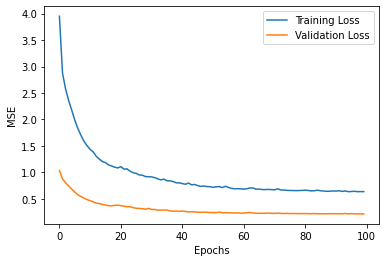

In [9]:
if not isTrain:
    with open(SAVE_PATH, 'r') as f:
        loss_file = f.read().splitlines()[1]
    history = pd.read_csv(loss_file).to_dict(orient='list')
plt.figure()
plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Evaluate model

In [10]:
if not isTrain:
    model.load_state_dict(torch.load(MODEL_PATH))

### Perform on stylized model

In [11]:
from sklearn.metrics import r2_score
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device("cpu")
model.eval()

y = []
output = []
for X, Y in test_loader:
    y.append(Y.to("cpu").detach().numpy())
    output.append(model(X.to(device)).to("cpu").detach().numpy())
y = np.concatenate(y, axis=0)
output = np.concatenate(output, axis=0)

# back to original scale
for i, lb in enumerate(label_list):
    y[:,i] = org_scale(y[:,i], ranges[lb])
    output[:,i] = org_scale(output[:,i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
for i, p in enumerate(display_list):
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(y[:,i], output[:,i])))

R2 Score y-shift:   0.972
R2 Score d:         0.945
R2 Score theta:     0.750
R2 Score l_t:       0.540
R2 Score vx:        0.837
R2 Score vy / h:    0.409
R2 Score vz:        0.867
R2 Score phi:       0.629


Stylized Cell Testing Data: Ground Truth VS Predicted


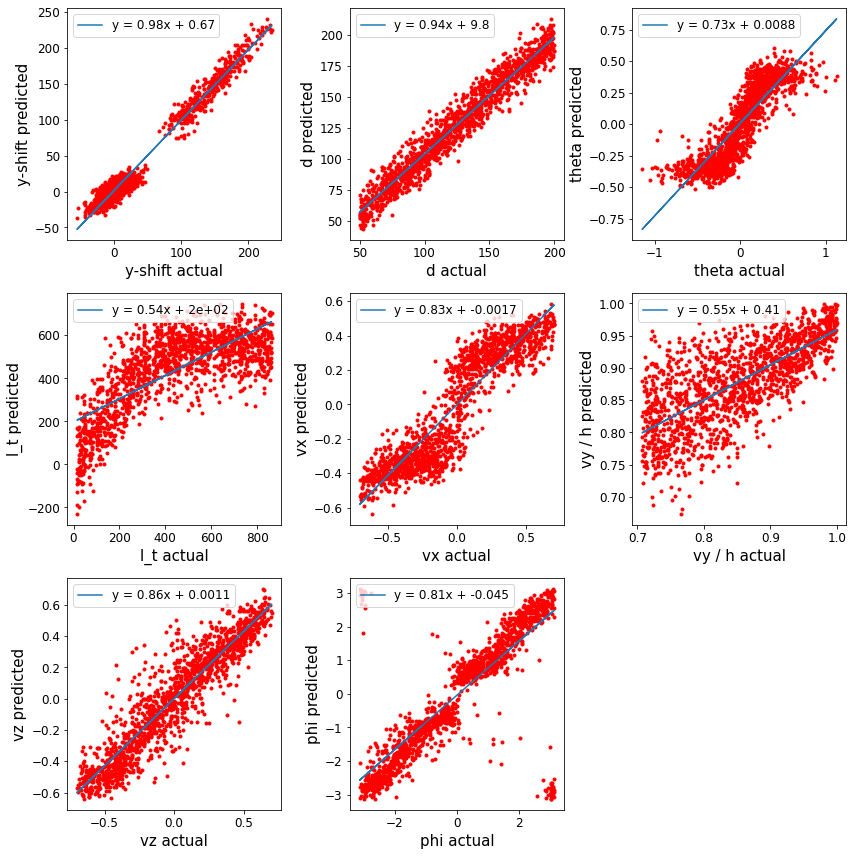

In [12]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:,i], output[:,i], c='red', marker='.')
    m, b = np.polyfit(y[:,i], output[:,i], 1)
    ax.plot(y[:,i], m * y[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

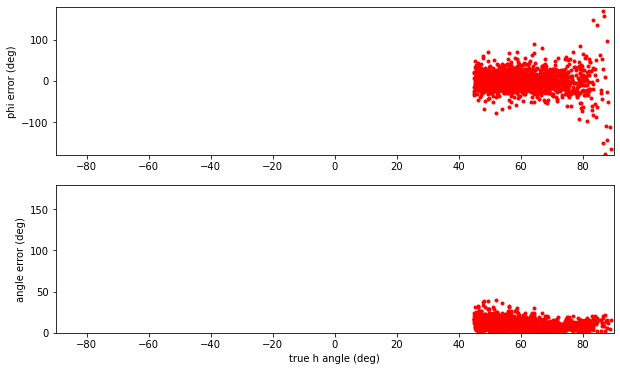

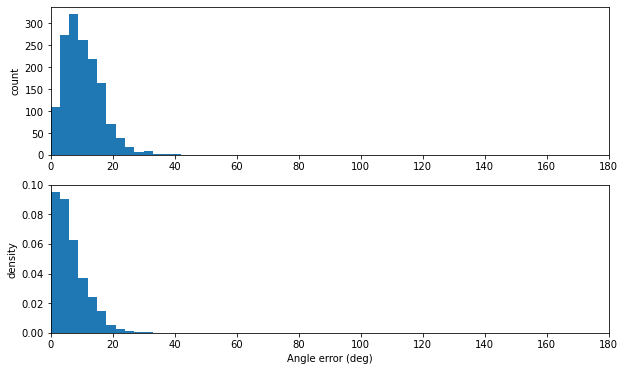

RMSE of angle: 12.1


In [13]:
if check_orient:
    def cosine_similarity(hphi1, hphi2):
        np.clip(hphi1[:,0], -1, 1, out=hphi1[:,0])
        np.clip(hphi2[:,0], -1, 1, out=hphi2[:,0])
        x1 = hphi2unitsphere(hphi1)
        x2 = hphi2unitsphere(hphi2)
        return np.sum(x1 * x2, axis=1)

    bins = 60
    angle = np.arccos(cosine_similarity(y[:, orient_idx2], output[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 4))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (output[:, orient_idx2[1]] - y[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(y[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-180, 180])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 180])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 180))
    plt.xlim([0, 180])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
    plt.xlim([0, 180])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)

### Perform on detailed model (Random cases)

In [ ]:
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_detailed.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed.npz')  # summary statistics
# STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed_strch.npz')  # summary statistics

#### Ground truth

In [15]:
STATS = np.load(STATS_PATH)
summ_stats_test = STATS['x']
labels_true = STATS['y']
if direction_vec:
    dv = hphi2unitsphere(labels_true[:, orient_idx0])
    labels_true = np.hstack([np.delete(labels_true, orient_idx0, axis=1), dv, labels_true[:, [orient_idx0[1]]]])
if has_yshift:
    labels_true[:, ys_idx] = STATS['ys']

#### Prediction

In [16]:
device = torch.device("cpu")
model.eval()

labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# back to original scale
for i, lb in enumerate(label_list):
    labels_pred[:,i] = org_scale(labels_pred[:,i], ranges[lb])

# transform orientation variables
if direction_vec:
    labels_pred[:, orient_idx1] = trivarnorm2unitsphere(labels_pred[:, orient_idx1])
    labels_pred = np.hstack([labels_pred, unitsphere2hphi(labels_pred[:, orient_idx1])[:, [1]]])

for i, p in enumerate(display_list):
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(labels_true[:,i], labels_pred[:,i])))

R2 Score y-shift:   0.268
R2 Score d:         0.646
R2 Score theta:     0.798
R2 Score vx:        -0.013
R2 Score vy / h:    -1.624
R2 Score vz:        -0.573
R2 Score phi:       -1.139


Detailed Cell Testing Data: Ground Truth VS Predicted


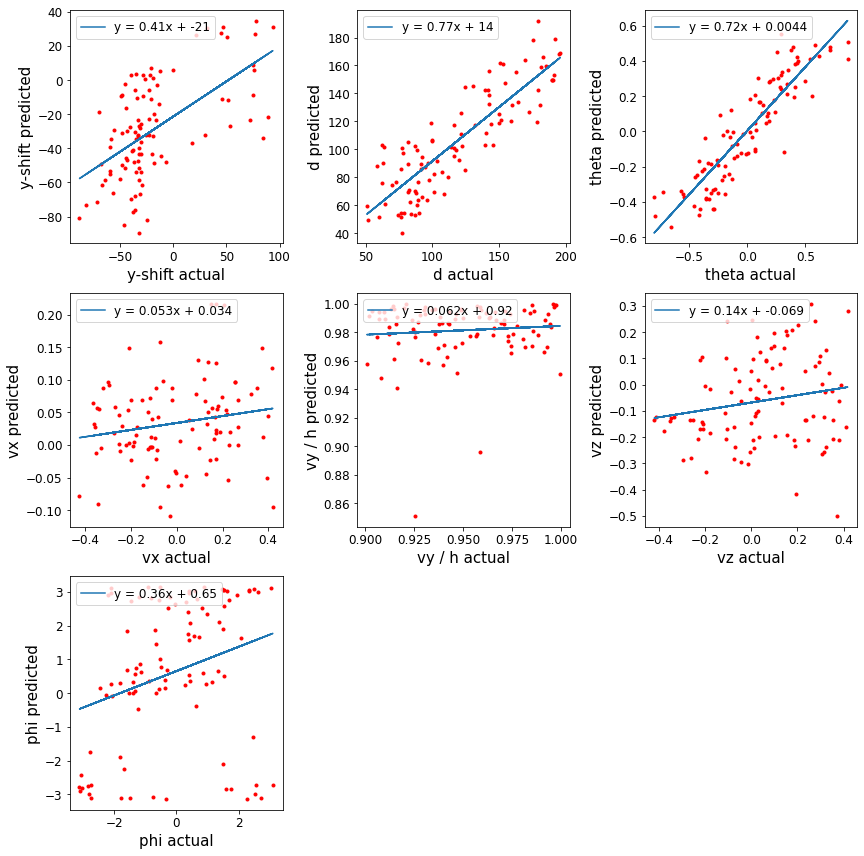

In [17]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Detailed Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(labels_true[:,i], labels_pred[:,i], c='red', marker='.')
    m, b = np.polyfit(labels_true[:,i], labels_pred[:,i], 1)
    ax.plot(labels_true[:,i], m * labels_true[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

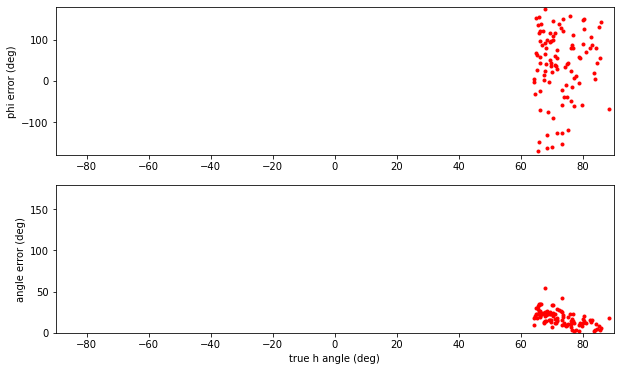

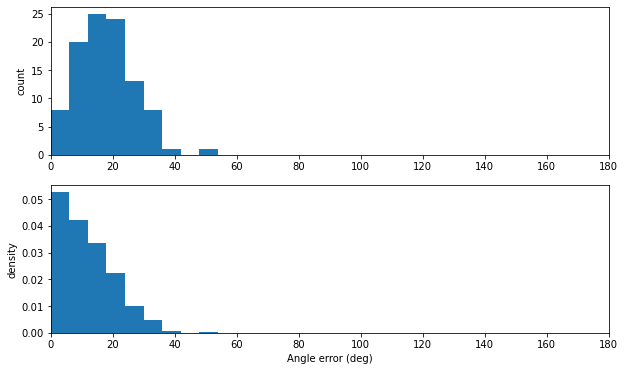

RMSE of angle: 20.4


In [18]:
if check_orient:
    bins = 30
    angle = np.arccos(cosine_similarity(labels_true[:, orient_idx2], labels_pred[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 4))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (labels_pred[:, orient_idx2[1]] - labels_true[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(labels_true[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-180, 180])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 180])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 180))
    plt.xlim([0, 180])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
    plt.xlim([0, 180])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)